In [1]:
!pip install ucimlrepo
!pip install mlxtend

In [3]:
#import needed librarys
from ucimlrepo import fetch_ucirepo 
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder ,  StandardScaler ,label_binarize
import joblib
from mlxtend.frequent_patterns import association_rules , apriori
from imblearn.over_sampling import SMOTENC
from sklearn.feature_selection import VarianceThreshold
from sklearn.cluster import KMeans, DBSCAN , AgglomerativeClustering
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np 
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score ,precision_score ,recall_score ,f1_score , silhouette_score , roc_curve, auc
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

In [5]:
# fetch dataset 
estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition = fetch_ucirepo(id=544) 
  
# data
X = estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition.data.features 
y = estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition.data.targets 
  
# metadata 
print(estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition.metadata) 
  
# variable information 
print(estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition.variables) 


# Check for missing values in the features
print("Missing values in X (features):")
print(X.isnull().sum())

# Check for missing values in the target 
print("\nMissing values in y (target):")
print(y.isnull().sum())

# Verify no missing values
print("\nAre there any missing values in X? ", X.isnull().values.any())
print("Are there any missing values in y? ", y.isnull().values.any())



{'uci_id': 544, 'name': 'Estimation of Obesity Levels Based On Eating Habits and Physical Condition ', 'repository_url': 'https://archive.ics.uci.edu/dataset/544/estimation+of+obesity+levels+based+on+eating+habits+and+physical+condition', 'data_url': 'https://archive.ics.uci.edu/static/public/544/data.csv', 'abstract': 'This dataset include data for the estimation of obesity levels in individuals from the countries of Mexico, Peru and Colombia, based on their eating habits and physical condition. ', 'area': 'Health and Medicine', 'tasks': ['Classification', 'Regression', 'Clustering'], 'characteristics': ['Multivariate'], 'num_instances': 2111, 'num_features': 16, 'feature_types': ['Integer'], 'demographics': ['Gender', 'Age'], 'target_col': ['NObeyesdad'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2019, 'last_updated': 'Tue Sep 10 2024', 'dataset_doi': '10.24432/C5H31Z', 'creators': [], 'intro_paper': {'ID': 358, 'type': 

Data Encoding and Preprocessing

In [13]:
# Encode categorical features
X_encoded = X.copy()
label_encoders = {}
categorical_columns = []

for col in X.columns:
    if X[col].dtype == 'object':  # Encode categorical columns
        categorical_columns.append(X.columns.get_loc(col)) 
        label_encoders[col] = LabelEncoder()
        X_encoded[col] = label_encoders[col].fit_transform(X[col])

# Encode target
y_encoded = LabelEncoder().fit_transform(y.values.ravel())

# SMOTE-NC for oversampling
smote_nc = SMOTENC(categorical_features=categorical_columns, random_state=42)
X_resampled, y_resampled = smote_nc.fit_resample(X_encoded, y_encoded)

#Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)

print(X_scaled)


[[-1.02014591 -0.50529512 -0.87830839 ...  0.55497812  1.39698746
   0.49965301]
 [-1.02014591 -0.50529512 -1.95169828 ... -1.10028076 -0.53893933
   0.49965301]
 [ 0.98025193 -0.18737335  1.05379342 ...  0.55497812 -2.47486611
   0.49965301]
 ...
 [ 0.98025193 -0.13725125  0.13555939 ... -0.73992991 -0.53893933
   0.49965301]
 [-1.02014591 -0.81440726 -0.75307768 ...  0.55497812 -0.53893933
   0.49965301]
 [ 0.98025193  1.4220008  -0.07783737 ... -1.10028076  1.39698746
  -1.90122204]]


Clustering / K-Means Hierarchical Clustering

K-Means Silhouette Score: 0.6101547702355019
Hierarchical Clustering Silhouette Score: 0.721822888159071


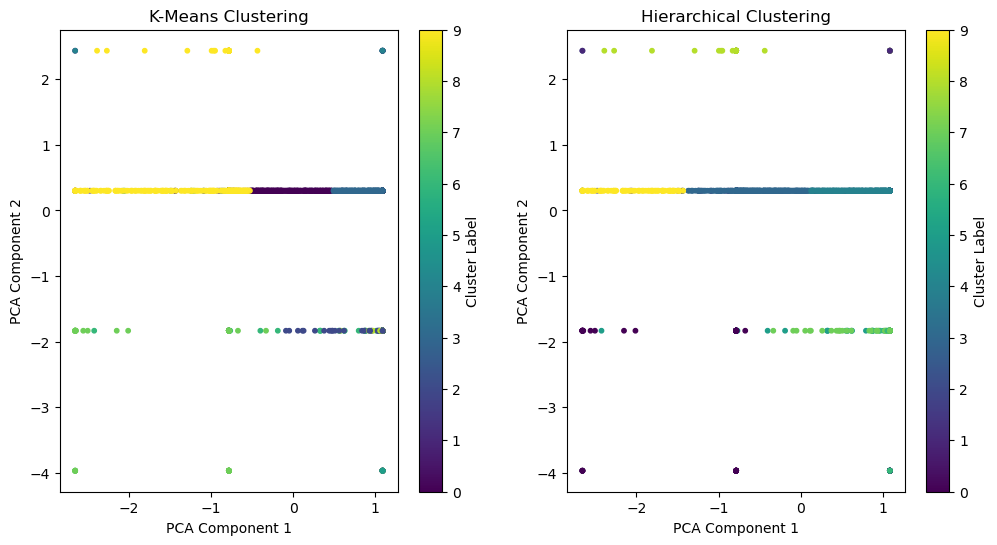

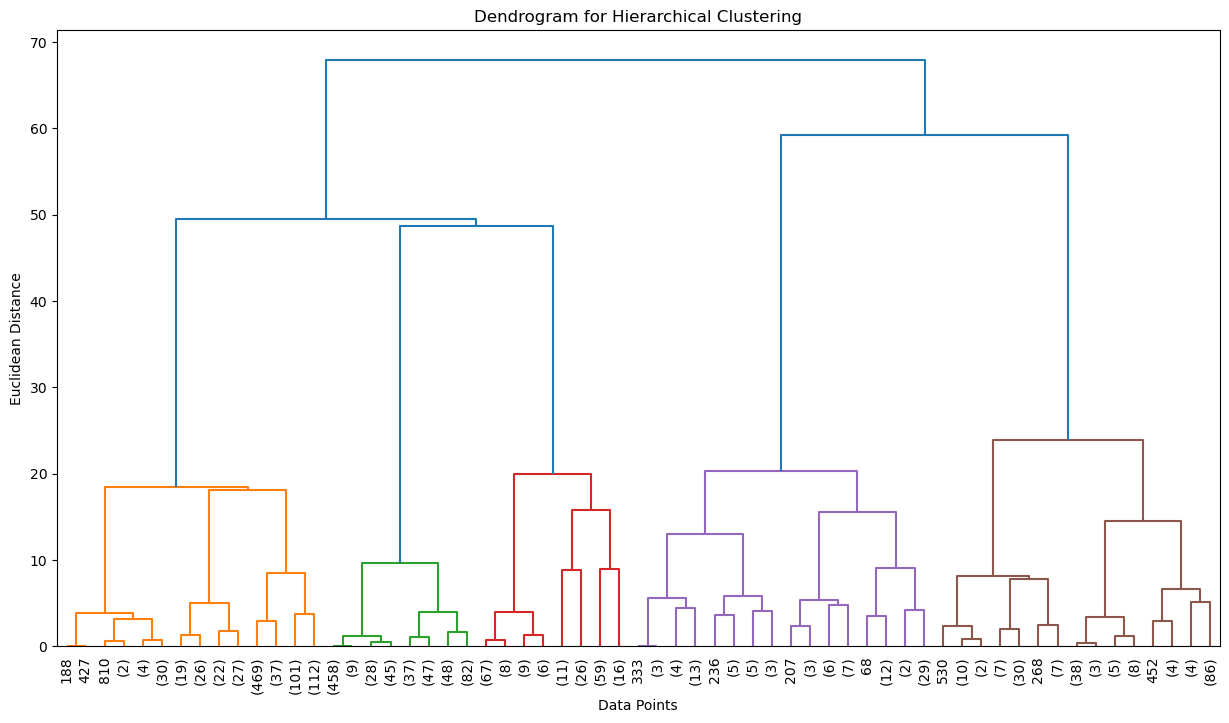

In [9]:
#Feature selection
top_features = ["FCVC", "CAEC", "SCC", "FAVC"]  
X_selected = X_encoded[top_features] if top_features else X_selected

# Scale the features
X_scaled = scaler.fit_transform(X_selected)

# K-Means
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)
kmeans_silhouette = silhouette_score(X_scaled, kmeans_labels)

# Plot K-Means results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=kmeans_labels, cmap='viridis', s=10)
plt.title("K-Means Clustering")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label="Cluster Label")

print(f"K-Means Silhouette Score: {kmeans_silhouette}")

# Hierarchical Clustering
hierarchical = AgglomerativeClustering(n_clusters=10)
hierarchical_labels = hierarchical.fit_predict(X_scaled)
hierarchical_silhouette = silhouette_score(X_scaled, hierarchical_labels)

# Plot Hierarchical Clustering
plt.subplot(1, 2, 2)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=hierarchical_labels, cmap='viridis', s=10)
plt.title("Hierarchical Clustering")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label="Cluster Label")
print(f"Hierarchical Clustering Silhouette Score: {hierarchical_silhouette}")

#Perform linkage 
linkage_matrix = linkage(X_scaled, method='ward')

# Plot the dendrogram
plt.figure(figsize=(15, 8))
dendrogram(linkage_matrix, truncate_mode='level', p=5, leaf_rotation=90, leaf_font_size=10)
plt.title("Dendrogram for Hierarchical Clustering")
plt.xlabel("Data Points")
plt.ylabel("Euclidean Distance")
plt.show()

Association Rule Mining / Applying Apriori and Association Rule Mining

In [15]:
# binarize the data for apriori 
X_boolean = (X_scaled > 0).astype(int)  # Threshold to create boolean array
X_boolean_df = pd.DataFrame(X_boolean, columns=[f"Feature_{i}" for i in range(X_boolean.shape[1])])

min_support = 0.05
frequent_itemsets = apriori(X_boolean_df, min_support=min_support, use_colnames=True)

print(frequent_itemsets)

    # Generate association rules 
    # Due to version error in mlxtend library num_itemsets=2 may needed to be added. It did not effect the outcomes.
   
min_confidence = 0.8
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_confidence )

rules = rules[ (rules['lift'] > 1.0)]

print(rules)
#for future selection 
rules.to_csv("filtered_association_rules.csv", index=False)
#if there is only 5 rule. Please re-run the preprocessing code then re-run assosocation rule mining code   


C:\Users\Quesh_yoda\anaconda3\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


       support                                           itemsets
0     0.509972                                        (Feature_0)
1     0.369963                                        (Feature_1)
2     0.496540                                        (Feature_2)
3     0.433048                                        (Feature_3)
4     0.815222                                        (Feature_4)
...        ...                                                ...
4009  0.055759  (Feature_4, Feature_8, Feature_2, Feature_7, F...
4010  0.055352  (Feature_13, Feature_4, Feature_8, Feature_2, ...
4011  0.057387  (Feature_13, Feature_4, Feature_8, Feature_2, ...
4012  0.053724  (Feature_13, Feature_4, Feature_8, Feature_7, ...
4013  0.050468  (Feature_13, Feature_4, Feature_8, Feature_2, ...

[4014 rows x 2 columns]
                                             antecedents  \
0                                            (Feature_0)   
1                                            (Feature_0)   
2  

Confusion Matrix:
 [[66  2  0  0  0  0  0]
 [ 1 68  0  0  0  5  0]
 [ 0  1 66  1  0  0  0]
 [ 0  0  1 69  0  0  0]
 [ 0  0  0  0 74  0  0]
 [ 0  3  0  0  0 63  0]
 [ 0  2  2  0  0  0 68]]
Accuracy Score: 0.9634146341463414
Classification Report:
Accuracy: 0.9634
Precision: 0.9642
Recall: 0.9634
F1-Score: 0.9636


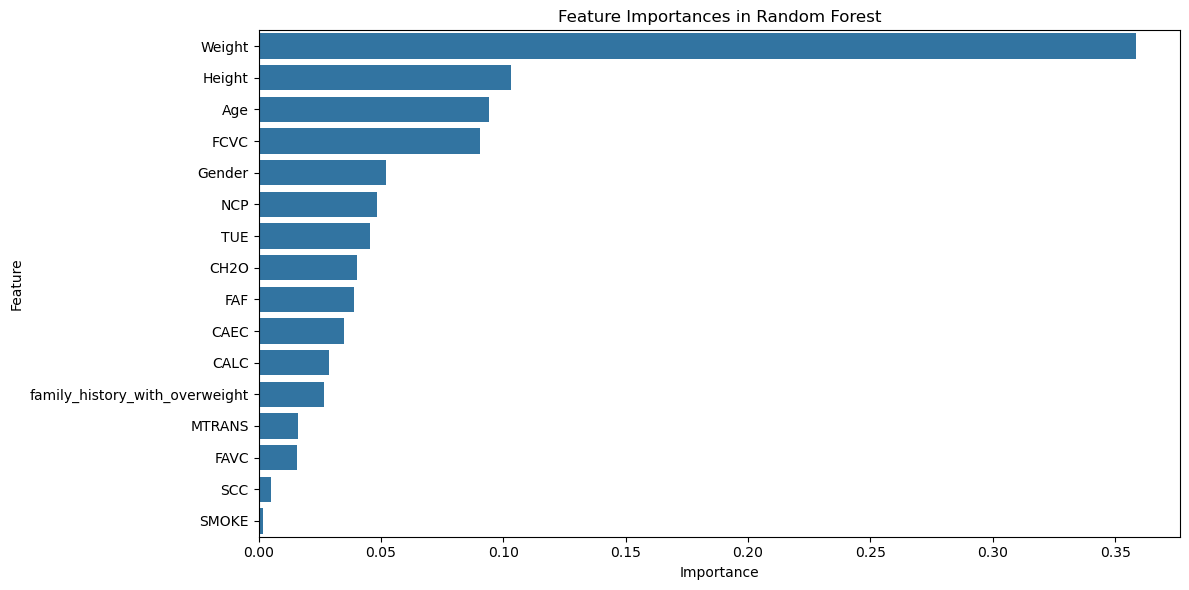

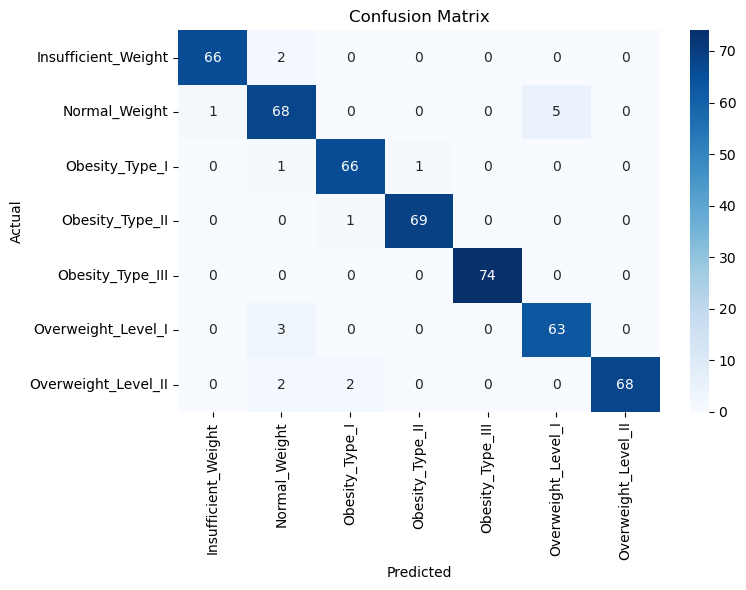

In [17]:
#Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_resampled, test_size=0.2, random_state=42)

#Train a Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

#Make predictions
y_pred = rf_classifier.predict(X_test)

#Evaluate the model
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))

print("Classification Report:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_test, y_pred, average='weighted'):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred, average='weighted'):.4f}")

#Visualize feature importance
feature_importances = rf_classifier.feature_importances_
features = X_encoded.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importances in Random Forest')
plt.tight_layout()
plt.show()

#Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()


Comparison of other classification algorithms

In [19]:
# Initialize and train kNN model
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(X_train, y_train)

# Make predictions
y_pred_knn = knn_classifier.predict(X_test)

# Evaluate the model
print("\nk-Nearest Neighbors (kNN) Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_knn):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_knn, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_knn, average='weighted'):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_knn, average='weighted'):.4f}")



k-Nearest Neighbors (kNN) Evaluation:
Accuracy: 0.8028
Precision: 0.7966
Recall: 0.8028
F1-Score: 0.7918


In [21]:
# Initialize and train ANN model
ann_classifier = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
ann_classifier.fit(X_train, y_train)

# Make predictions
y_pred_ann = ann_classifier.predict(X_test)

# Evaluate the model
print("\nArtificial Neural Network (ANN) Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_ann):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_ann, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_ann, average='weighted'):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_ann, average='weighted'):.4f}")



Artificial Neural Network (ANN) Evaluation:
Accuracy: 0.9492
Precision: 0.9497
Recall: 0.9492
F1-Score: 0.9494


In [23]:
# Initialize and train Decision Tree model
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train, y_train)

# Make predictions
y_pred_dt = dt_classifier.predict(X_test)

# Evaluate the model
print("\nDecision Tree Classifier Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_dt):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_dt, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_dt, average='weighted'):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_dt, average='weighted'):.4f}")



Decision Tree Classifier Evaluation:
Accuracy: 0.9350
Precision: 0.9361
Recall: 0.9350
F1-Score: 0.9345


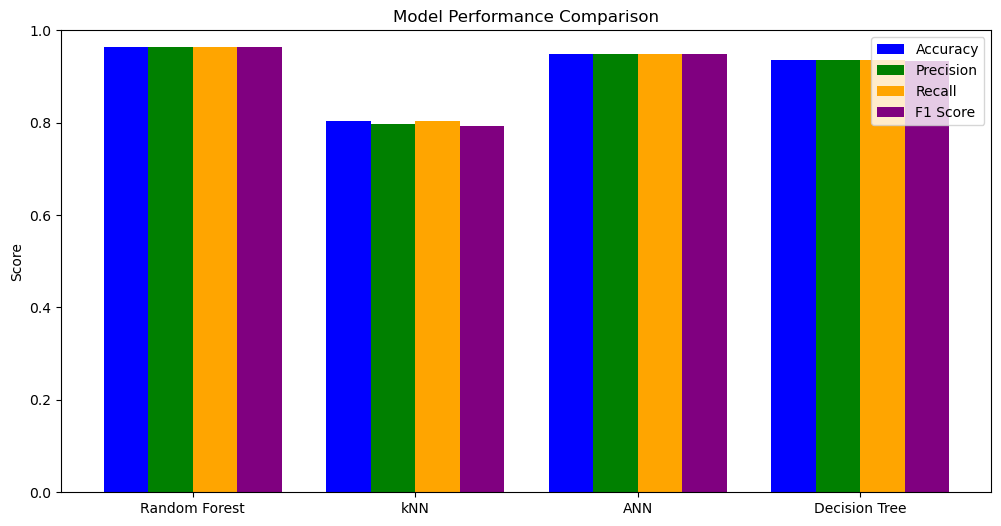

In [25]:
# Function to evaluate the model
def evaluate_model(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    return accuracy, precision, recall, f1

# Train Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred_rf = rf_classifier.predict(X_test)
metrics_rf = evaluate_model(y_test, y_pred_rf)

# Train kNN model
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(X_train, y_train)
y_pred_knn = knn_classifier.predict(X_test)
metrics_knn = evaluate_model(y_test, y_pred_knn)

# Train ANN model
ann_classifier = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
ann_classifier.fit(X_train, y_train)
y_pred_ann = ann_classifier.predict(X_test)
metrics_ann = evaluate_model(y_test, y_pred_ann)

# Train Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train, y_train)
y_pred_dt = dt_classifier.predict(X_test)
metrics_dt = evaluate_model(y_test, y_pred_dt)

# Collecting metrics
models = ['Random Forest', 'kNN', 'ANN', 'Decision Tree']
accuracy = [metrics_rf[0], metrics_knn[0], metrics_ann[0], metrics_dt[0]]
precision = [metrics_rf[1], metrics_knn[1], metrics_ann[1], metrics_dt[1]]
recall = [metrics_rf[2], metrics_knn[2], metrics_ann[2], metrics_dt[2]]
f1_score_values = [metrics_rf[3], metrics_knn[3], metrics_ann[3], metrics_dt[3]]

# Plotting the metrics
x = range(len(models))
plt.figure(figsize=(12, 6))

plt.bar(x, accuracy, width=0.2, label='Accuracy', color='blue', align='center')
plt.bar([i + 0.2 for i in x], precision, width=0.2, label='Precision', color='green', align='center')
plt.bar([i + 0.4 for i in x], recall, width=0.2, label='Recall', color='orange', align='center')
plt.bar([i + 0.6 for i in x], f1_score_values, width=0.2, label='F1 Score', color='purple', align='center')

# Adding labels and legend
plt.xticks([i + 0.3 for i in x], models)
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.ylim(0, 1)
plt.legend(loc='upper right')
plt.show()
